<a href="https://colab.research.google.com/github/JielingChen/optimizing_conversion_rate/blob/main/Optimizing_Conversion_Rate_Part_1_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).  

# Goal
The goal of this project:
* __Build a model that predicts conversion rate__
* __Come up with recommendations for the product team and the marketing team to improve conversion rate__

# Data
Columns:
* country : user country based on the IP address
* age : user age. Self-reported at sign-in step
* new_user : whether the user created the account during this session or had already an account and simply came back to the site
* source : marketing channel source
> 1. Ads: came to the site by clicking on an advertisement
> 1. Seo: came to the site by clicking on search results
> 1. Direct: came to the site by directly typing the URL on the browser
* total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

__This notebook is the first part of this project.__  

## 1. Exploratory Data Analysis
Before we implement any machine learning model, it's important to perform Exploratory Data Analysis(EDA) on the data set. We need to know our data through inspecting and visualization first, then we will be able to know how to preprocess our data for machine learning, and also gain insights on which machine learning models would be appropriate to solve our problems. What's more, through the process of EDA, we can get insights into the operation of our business, which would be helpful for us to come up with advice on how to improve the operation. 

Let's get started!

In [62]:
# import the libraries
import pandas as pd
import numpy as np

In [63]:
# read the data set
data = pd.read_csv('/content/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [64]:
# find out how many data points are in the data set
len(data)

316200

### 1.1 Inspecting Data

Check the data type of each column and whether there is missing data:

In [65]:
# get information about the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


__Findings:__
* The country and source are categorical data, while the others are numeric data.  
* No column has missing data, which is a very ideal situation, but note that it rarely happens in the real world.

Inspect the summary statistics of the data:

In [66]:
# first we need to distinguish numeric data and categorical data

# get the column names of the data set
columns = pd.Series(data.columns)

# make a list of column names of categorical data
cat_col = ['country','source']

# make a list of column names of numeric data
num_col = list(columns[~columns.isin(cat_col)])

# get the subset of the data set which only contains categorical data
data_cat = data[cat_col]

# get the subset of the data set which only contains numeric data
data_num = data[num_col]

# inspect these 2 subsets
print(data_cat.describe())
print(data_num.describe())

       country  source
count   316200  316200
unique       4       3
top         US     Seo
freq    178092  155040
                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


__Finding:__
* Our users were from 4 different countries, and came to our website through 3 different marketing channel sources. __Almost 1/2 of the users were from the US,__ and __roughly 1/2 of the users came to our website by clicking on search results.__  

* In the age column, The min, median, and 75% percentile are 17, 30, and 36 years old respectively, which __indicates our users were mainly young adults__.
The max is 123 years old, which is an out-of-range data point that needs to be dropped. 
* In the new_user column, the mean is 0.6854, which means __68.54% of users created an account during this session__. 

* In the total_pages_visited column, we can see that __users visited 4.87 pages on average during the session__.

* In the converted column, we can see that only __3.2% of the users were converted__.

In [67]:
# inspect the out-of-range data we found in the age column
age_over_100 = data[data['age'] >= 100]
age_over_100

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two out-of-range data, so we can simply drop them.

In [68]:
# drop the out-of-range data
data = data[data['age'] < 100]
data.count()

country                316198
age                    316198
new_user               316198
source                 316198
total_pages_visited    316198
converted              316198
dtype: int64

### 1.2 Visualizing Data
After initial inspecting, let's visualize the data to get insights more intuitively.

In [69]:
# import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

Since we are interested in the conversion rate, so let's find out the relationships between the conversion rate and other features in our data.

Note that a high conversion rate would be impactful only if the base number is big as well, so we also need to keep our eyes on the total user numbers of different countries, marketing sources and age groups.

#### 1.2.1 Conversion Rate and Demographic Characteristics
##### 1.2.1.1 Conversion Rate and Countries

Let's visualize the numbers of users from different countries:

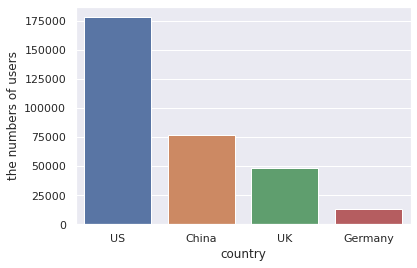

In [70]:
# create a country name list ordered by the numbers of users descendingly
order_country = list(data['country'].value_counts(sort=True).index)

# create a count plot of the numbers of users in each country
sns.countplot(x="country", data=data, order=order_country)
plt.ylabel('the numbers of users')
plt.show()

__Finding:__
* The US had the biggest user base, while Germany had the least. China and the UK were in between.

Let's find out the conversion rates among different countries:

In [71]:
# create a dataframe showing how many users were converted in each country
convert_num_country = data.groupby('country')[['converted']].sum()
convert_num_country.reset_index(inplace=True)
convert_num_country

,country,converted
0,China,102
1,Germany,815
2,UK,2549
3,US,6732


In [72]:
# create a series showing how many users were from each country
user_num_country = data[['country']].value_counts(sort=False)
print(user_num_country)

# assign the series to the dataframe
convert_country = convert_num_country.assign(user_total = user_num_country.values)
convert_country

country
China       76602
Germany     13055
UK          48449
US         178092
dtype: int64


,country,converted,user_total
0,China,102,76602
1,Germany,815,13055
2,UK,2549,48449
3,US,6732,178092


In [73]:
# calculate the conversion rates of each country and assign it to the dataframe
convert_country = convert_country.assign(convert_rate = lambda x: x['converted'] / x['user_total'])
convert_country

,country,converted,user_total,convert_rate
0,China,102,76602,0.001332
1,Germany,815,13055,0.062428
2,UK,2549,48449,0.052612
3,US,6732,178092,0.037801


Let's visualize the conversion rates in different countries:

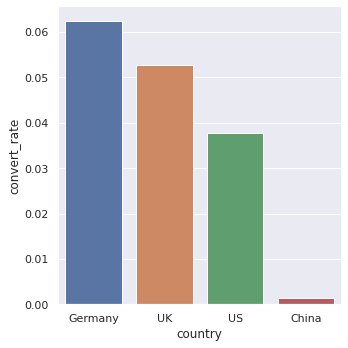

In [74]:
# create a country name list ordered by the conversion rates descendingly
order_rate_country = list(convert_country[['country','convert_rate']].sort_values(by='convert_rate', ascending=False)['country'])

# create a bar plot of conversion rates of each country
sns.catplot(x='country', y='convert_rate', data=convert_country, kind='bar', order=order_rate_country)
plt.show()

__Finding:__

We found something interesting in the graph:
* Although the users from Germany were the least, Germany had the highest conversion rate.
* China had the second largest user base, but the conversion rate was significantly lower than the other 3 countries.
* Although the user base of the US was bigger than the UK, the conversion rate of the US was lower than that of the UK.


##### 1.2.1.2 Conversion Rate and Age

Let's visualize the numbers of users from different age groups:

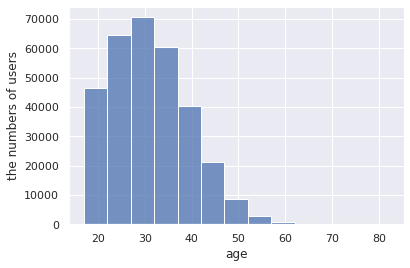

In [75]:
# create a histogram of the numbers of users in each age group
sns.histplot(x='age', data=data, binwidth=5)
plt.ylabel('the numbers of users')
plt.show()

__Finding:__

* Most of our users were aged 20 - 40 years old.

Let's find out whether age has an influence on conversion or not:

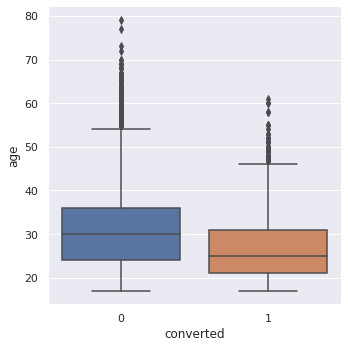

In [76]:
# create a box plot showing the age distributions among the converted and unconverted users
sns.catplot(x='converted', y='age', data=data, kind='box')
plt.show()

__Finding:__

* The converted users were overall younger than the unconverted users, which indicates there might be a relationship between age and conversion.

Let's find out if age has a linear relation with conversion:

In [77]:
# calculate how many users were converted in each age group
convert_num_age = data.groupby('age')[['converted']].sum()
convert_num_age.reset_index(inplace=True)
convert_num_age.head()

,age,converted
0,17,544
1,18,559
2,19,548
3,20,580
4,21,592


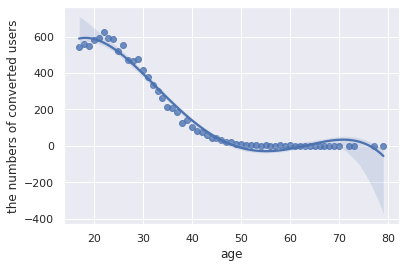

In [78]:
# create a regression plot showing the relationship between age and the number of converted users
sns.regplot(data=convert_num_age, x='age',  y='converted', order=4)
plt.ylabel('the numbers of converted users')
plt.show()

__Finding:__
* Age had a 4th-degree polynomial curvilinear relationship with the the number of the converted users. 

#### 1.2.2 Conversion Rate and Marketing Channel Sources

Let's visualize the numbers of users from different marketing channel sources:

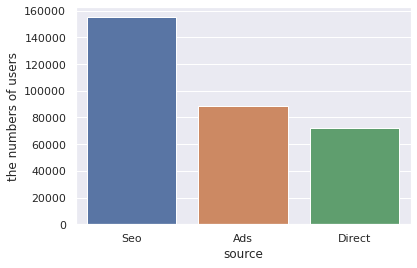

In [79]:
# create a source name list ordered by the numbers of users descendingly
order_source = list(data['source'].value_counts(sort=True).index)

# create a count plot of the numbers of users from each source
sns.countplot(x="source", data=data, order=order_source)
plt.ylabel('the numbers of users')
plt.show()

__Finding:__
* The seo source brought the most users to our website, which accounted for roughly 1/2 of the users. 
* The ads source was slightly better than the direct source.  

Let's find out the conversion rate among different sources:

In [80]:
# create a dataframe showing how many users were converted from each source
convert_num_source = data.groupby('source')[['converted']].sum()
convert_num_source.reset_index(inplace=True)
print(convert_num_source)

# create a series showing the total numbers of users from each source
user_num_source = data[['source']].value_counts(sort=False)
# assign the series to the dataframe
convert_source = convert_num_source.assign(user_total = user_num_source.values)
print(convert_source)

# calculate the conversion rates of each source and assign it to the dataframe
convert_source = convert_source.assign(convert_rate = lambda x: x['converted'] / x['user_total'])
convert_source

   source  converted
0     Ads       3059
1  Direct       2040
2     Seo       5099
   source  converted  user_total
0     Ads       3059       88739
1  Direct       2040       72420
2     Seo       5099      155039


,source,converted,user_total,convert_rate
0,Ads,3059,88739,0.034472
1,Direct,2040,72420,0.028169
2,Seo,5099,155039,0.032888


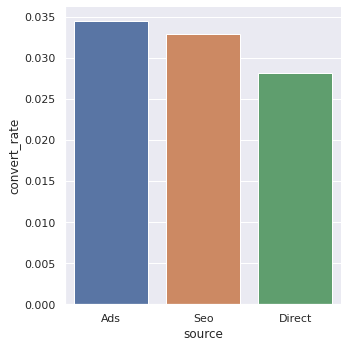

In [81]:
# create a source name list ordered by the conversion rates descendingly
order_rate_source = list(convert_source[['source','convert_rate']].sort_values(by='convert_rate', ascending=False)['source'])

# create a bar plot of conversion rates of each source
sns.catplot(x='source', y='convert_rate', data=convert_source, kind='bar', order=order_rate_source)
plt.show()

__Finding:__
* The ads source had the biggest conversion rate, while the direct source had the least. The conversion rate of the seo source was close to that of the ads source.

#### 1.2.3 Conversion Rate and User Engagement

Let's find out how many pages a user visited during the session:

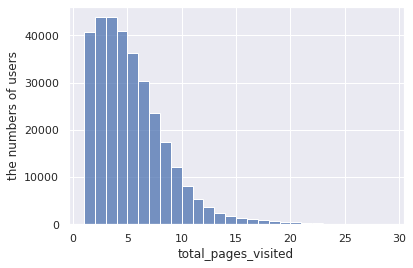

In [82]:
# create a histogram of the total numbers of users of each number of pages visited by a user
sns.histplot(x='total_pages_visited', data=data, binwidth=1)
plt.ylabel('the numbers of users')
plt.show()

__Finding:__
* Most users visited 1-7 pages during the session.

Let's find out whether user engagement has an influence on conversion or not:

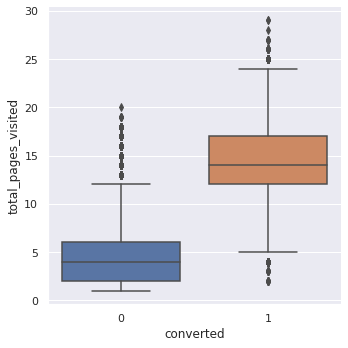

In [83]:
# create a box plot showing the total_pages_visited distributions among the converted and unconverted users
sns.catplot(x='converted', y='total_pages_visited', data=data, kind='box')
plt.show()

__Finding:__
* The converted users overall had more engagement than the unconverted users.
* Most converted users visited 12-17 pages during the session.

Let's find out if the total pages visited by a user during the session has a linear relation with conversion:

In [84]:
# calculate how many users were converted in each total_pages_visited
convert_num_pages = data.groupby('total_pages_visited')[['converted']].sum()
convert_num_pages.reset_index(inplace=True)
convert_num_pages.head()

,total_pages_visited,converted
0,1,0
1,2,10
2,3,11
3,4,32
4,5,57


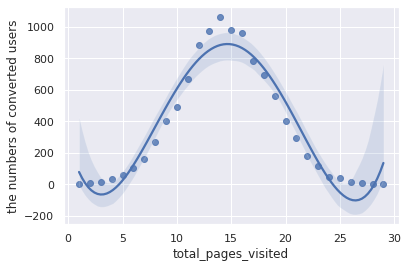

In [85]:
# create a regression plot showing the relationship between total_pages_visited and the number of converted users
sns.regplot(data=convert_num_pages, x='total_pages_visited',  y='converted', order=4)
plt.ylabel('the numbers of converted users')
plt.show()

__Finding:__
* The total pages visited by a user during the session had a 4th-degree polynomial curvilinear relationship with the number of converted users. 

#### 1.2.4 Conversion Rate and New Users

Let's visualize the total numbers of the old users and the new users:

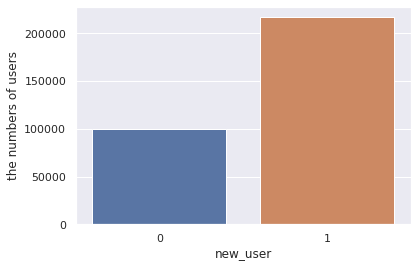

In [86]:
# create a count plot of the numbers of users of the old users and the new users
sns.countplot(x="new_user", data=data)
plt.ylabel('the numbers of users')
plt.show()

__Finding:__
* Roughly 2/3 of the users who came to our website were new users.

Let's find out whether the new users and the old users had difference in conversion rates:

In [87]:
# create a dataframe showing how many old users and new users were converted
convert_num_new_user = data.groupby('new_user')[['converted']].sum()
convert_num_new_user.reset_index(inplace=True)
print(convert_num_new_user)

# create a series showing how many users were the old users and how many users were the new users and assign it to the dataframe
user_num_new= data[['new_user']].value_counts(sort=False)
convert_new_user = convert_num_new_user.assign(user_total = user_num_new.values)
print(convert_new_user)

# calculate the conversion rates of the old users and the new users
convert_new_user = convert_new_user.assign(convert_rate = lambda x: x['converted'] / x['user_total'])
convert_new_user

   new_user  converted
0         0       7159
1         1       3039
   new_user  converted  user_total
0         0       7159       99454
1         1       3039      216744


,new_user,converted,user_total,convert_rate
0,0,7159,99454,0.071983
1,1,3039,216744,0.014021


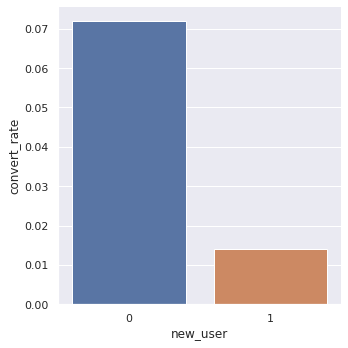

In [88]:
# create a bar plot of conversion rates of the old users and the new users
sns.catplot(x='new_user', y='convert_rate', data=convert_new_user, kind='bar')
plt.show()

__Finding:__
* The conversion rate of the old users was 7 times higher than the new users.

### 1.3 Summary of Findings From EDA

__Country:__
* Our users were from 4 different countries: the US, China, the UK and Germany. Almost 1/2 of the users were from the US, while Germany had the least user base, and China and the UK were in between.
* Although the users from Germany were the least, Germany had the highest conversion rate.
* China had the second largest user base, but the conversion rate was significantly lower than the other 3 countries.
* Although the user base of the US was bigger than the UK, the conversion rate of the US was lower than that of the UK.  


__Marketing source:__
* Our users came to our website through 3 different marketing channel sources, and roughly 1/2 of the users came to our website by clicking on search results. The ads source was slightly better than the direct source.  
* The ads source had the biggest conversion rate, while the direct source had the least. The conversion rate of the seo source was close to that of the ads source.  


__Age:__
* The minimum, median, and 75% percentile of user age were 17, 30, and 36 years old respectively, which indicates our users were mainly young adults.
* Most of our users were aged 20 - 40 years old.
* The converted users were overall younger than the unconverted users.
* Age had a 4th-degree polynomial curvilinear relationship with the number of converted users.  


__Engagement:__
* Users visited 4.87 pages on average during the session.
* Most users visited 1-7 pages during the session.
* The converted users overall had more engagement than the unconverted users.
* Most converted users visited 12-17 pages during the session.
* The total number of pages visited by a user during the session had a 4th-degree polynomial curvilinear relationship with the number of converted users.  


__New user:__
* Roughly 2/3 of the users were new users.
* The conversion rate of the old users was 7 times higher than the new users.  


__Conversion:__
* Only 3.2% of the users were converted.